# Credit Card Fraud Analysis

Script to explore prediction of fraud with the following dataset:
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi.
Calibrating Probability with Undersampling for Unbalanced Classification.
In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

The dataset can be downloaded from:
https://www.kaggle.com/dalpozz/creditcardfraud

The approach will be to use an autoencoder to understand learn about the dataset
and to identify the transactions with the biggest error from the autoencoder reconstruction.

The autoencoder will then be used as pre-training for a neural network classifier

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
%qtconsole

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import torch.cuda
from torch import nn as nn
from torch import optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sklearn as skl
import matplotlib.pyplot as plt
import os

In [4]:
# define analysis hyper-parameters
batch_size=64
# Identify the shape of the encoder, which has to be re-created
hidden_nodes=[14,7]

In [5]:
# Check for GPU and CUDA libraries
HAS_CUDA=torch.cuda.is_available()

In [6]:
# Attempt to get consistant results during model development by fixing random seeds
torch.manual_seed(10)
if HAS_CUDA:
    torch.cuda.manual_seed(10)

In [7]:
import pickle
import feather
while True:
    case_name=input('Encoder case to use: ')
    directory=os.path.dirname(case_name)
    if os.path.exists(case_name):
        break
    else:
        print('Case does not exist!')

# Load parameters
fromPickle=[]
with open(case_name+'/'+'analysis_params.pkl', 'rb') as f:
    [batch_size, lr, no_epochs, hidden_nodes]=pickle.load(f)
    f.close 
    
# Load training and vallidation datasets
data_tr=feather.read_dataframe(f'{case_name}/data_tr.feather')
data_val=feather.read_dataframe(f'{case_name}/data_val.feather')
print('All data loaded')

Encoder case to use: base_case
All data loaded


In [8]:
# Create dataset, this time including the fraudulent cases and the target classes
CF_input_tr = data_tr.drop(['Class','Amt_To_Keep'], axis=1)
CF_target_tr = data_tr['Class']
CF_input_val = data_val.drop(['Class','Amt_To_Keep'], axis=1)
CF_target_val = data_val['Class']

# Convert arrays to PyTorch Tensors
CF_input_tr=torch.Tensor.float(torch.from_numpy(CF_input_tr.values))
CF_target_tr=torch.Tensor.long(torch.from_numpy(CF_target_tr.values))
CF_input_val=torch.Tensor.float(torch.from_numpy(CF_input_val.values))
CF_target_val=torch.Tensor.long(torch.from_numpy(CF_target_val.values))


### Create version of data for training the Autoencoder. 


In [9]:
# Re-Create AutoEncoder model
from AutoEncoders import AutoEncoder_Multi_Layer
num_features=CF_input_tr.shape[1]
AE_model=AutoEncoder_Multi_Layer(num_features, hidden_sizes=hidden_nodes)

# Load saved weights
if HAS_CUDA:
    AE_model.load_state_dict(torch.load(case_name+'/'+'demo_state_dict.pt'))
else:
    AE_model.load_state_dict(torch.load(case_name+'/'+'demo_state_dict_cpu.pt'))

if HAS_CUDA:
    AE_model.cuda()

In [10]:
# Create new model of combined AutoEncoder and Classifier

class ClassifyFromAE(nn.Module):

    def __init__(self, AE_Model, n_classes=2, n_hid_cl=[]):
        """
        Class to combine a pre-trained autoencoder with a classifier.  The classifier can have any number of hidden
        layers, which can be defined by passing a list to n_hid_cl, with the number of neurons in each layer, for
        example n_hid_cl=[20,10,5] would give three hidden layers with 20 10 and 5 neurons respectively
        
        if n_hid=[] then there will be no hidden layer and the output from the encode will be connected directly to
        the softmax
        
        Parameters:
        
        AE_Model - a pre-trained autoencoder model
        n_classes - the number of output classes
        n_hid_cl - A list containing the number of neurons for each hidden layer
        
        """
        super(ClassifyFromAE, self).__init__()
        #This is the pre-trained Autoencoder
        self.AE_Model=AE_Model
        
        # Number of output classes
        self.n_out=n_classes
        
        # define new layers for classification.  Use a nn.ModuleList to collect classifier layers
        # so that we can avoid training them in the early stage
        self.CF_layers=nn.ModuleList([])
        
        if not n_hid_cl:
            to_sm=nn.Linear(self.AE_Model.n_outer, self.n_out)
            self.CF_layers.append(to_sm)
        else:
            # We only go down this route if we need hidden layers in the classifier
            new_layer=nn.Linear(self.AE_Model.n_outer, n_hid_cl[0])
            self.CF_layers.append(new_layer)
            new_layer = self.activation
            self.CF_layers.append(new_layer)
            for layer in range(1, self.CF_n_hid):
                new_layer=nn.Linear(n_hid_cl[layer-1], n_hid_cl[layer])
                self.CF_layers.append(new_layer)
                new_layer = self.activation
                self.CF_layers.append(new_layer)
            # Add hidden layer linear layer to go from last layer of encoder to classifier
            to_sm=nn.Linear(n_hid_cl[-1], 2)
            self.CF_layers.append(to_sm)
        
        # Add final activation 
        last_relu=nn.LeakyReLU()
        self.CF_layers.append(last_relu)
        
        ## softmax and logliklihood layers (the latter is used for training the former for prediction)
        # Add classification for output and training
        self.lsm=nn.LogSoftmax()
        self.sm=nn.Softmax()

    def encoder(self, input):
        x = self.AE_Model.encoder(input)
        return x

    def decoder(self, input):
        x = self.AE_Model.decoder(input)
        return x

    def forward(self, input):
        x = self.encoder(input)
        x = self.decoder(x)
        for i in range(len(self.CF_layers)):
            x=self.CF_layers[i](x)
        x=self.lsm(x)
        return x

    def predict(self, input):
        x = self.encoder(input)
        x = self.decoder(x)
        for i in range(len(self.CF_layers)):
            x=self.CF_layers[i](x)
        x=self.sm(x)
        return x

In [11]:
# Create instance of the classifier (in this case with no hidden layer)

CF_model=ClassifyFromAE(AE_model, n_classes=2, n_hid_cl=[])

In [12]:
# Define classifier parameters and create model manager
#Control parameters
no_epochs_CF=2
#no_epoch_CF=1
lr_CF=0.001

# Put the model onto the graphics card if present
if HAS_CUDA:
    CF_model.cuda()
    
# Tell the model not to adjust the weights of the Autoencoder when optimising
for param in CF_model.AE_Model.parameters():
    param.requires_grad=False
    
CF_opt = optim.Adam(CF_model.CF_layers.parameters(), lr=lr_CF)

#Define loss function (this time Negative Log Likelihood for classifier)
CF_cost_function = nn.NLLLoss()

# Define scheduler to control adaption of learning rate with training
CF_sched = optim.lr_scheduler.ReduceLROnPlateau(CF_opt, mode='min', verbose=True, patience=2, factor=0.2)

from nnModels import NN_Manage

# Create training, test and prediction manager
CF_manager=NN_Manage(model = CF_model,
                     loss_function = CF_cost_function, 
                     optimizer = CF_opt, 
                     scheduler=CF_sched,
                     HAS_CUDA=HAS_CUDA)


In [13]:
# Print small number of weights to check whether they are changed
for layer in range(0, len(CF_model.AE_Model.layers), 2):
    weights=CF_model.AE_Model.layers[layer].weight.data[0:2,0:5].numpy()
    print(f"Weights for layer: {layer}")
    print(f"{weights[0,0:5]}\n {weights[1,0:5]}\n")

Weights for layer: 0
[ 1.2245404   1.2114868   1.2058173   1.2075868  -0.17145309]
 [-1.1535403 -1.1612524 -1.1340013 -1.15049    0.2566308]

Weights for layer: 2
[ 0.7022519  -0.8492081   0.38762277  0.23290102 -0.45779696]
 [0.05775605 0.90482885 0.80837315 0.07232201 0.4940859 ]

Weights for layer: 4
[-0.5069853   0.5117336  -0.21506779  1.3455712   0.530026  ]
 [-0.15557767  0.06707309 -0.03140653 -4.1155496   0.18079457]

Weights for layer: 6
[ 0.0094858  -0.00497618  0.01003123 -0.00709216 -0.00711273]
 [ 0.01943864  0.02288051  0.00334238 -0.00849101  0.00406838]



In [14]:
# Train classifier with the weights of the encoder frozen  
CF_test_loss=0

for epoch in range(2):
    train_loss=CF_manager.train(epoch, True, CF_input_tr, CF_target_tr, batch_size)
    CF_test_loss=CF_manager.test(epoch,CF_input_val, CF_target_val, batch_size)
    CF_manager.scheduler.step(CF_test_loss)

/home/johnrichmond/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0  Batch: 0 Loss: 0.741854
Train Epoch: 0  Batch: 100 Loss: 0.546692
Train Epoch: 0  Batch: 200 Loss: 0.503191
Train Epoch: 0  Batch: 300 Loss: 0.465228
Train Epoch: 0  Batch: 400 Loss: 0.404567
Train Epoch: 0  Batch: 500 Loss: 0.334225
Train Epoch: 0  Batch: 600 Loss: 0.235845
Train Epoch: 0  Batch: 700 Loss: 0.213547
Train Epoch: 0  Batch: 800 Loss: 0.172577
Train Epoch: 0  Batch: 900 Loss: 0.172087
Train Epoch: 0  Batch: 1000 Loss: 0.156164
Train Epoch: 0  Batch: 1100 Loss: 0.131156
Train Epoch: 0  Batch: 1200 Loss: 0.117207
Train Epoch: 0  Batch: 1300 Loss: 0.120121
Train Epoch: 0  Batch: 1400 Loss: 0.090223
Train Epoch: 0  Batch: 1500 Loss: 0.067666
Train Epoch: 0  Batch: 1600 Loss: 0.085666
Train Epoch: 0  Batch: 1700 Loss: 0.065954
Train Epoch: 0  Batch: 1800 Loss: 0.057507
Train Epoch: 0  Batch: 1900 Loss: 0.051788
Train Epoch: 0  Batch: 2000 Loss: 0.050614
Train Epoch: 0  Batch: 2100 Loss: 0.044304
Train Epoch: 0  Batch: 2200 Loss: 0.041240
Train Epoch: 0  Batch: 

In [15]:
# Save weights from final layer to see how they change in later optimization
if HAS_CUDA:
    init_weights=CF_model.CF_layers[-2].weight.data.cpu().numpy()
else:
    init_weights=CF_model.CF_layers[-2].weight.data.numpy()

In [16]:
# Print small number of weights to check whether they are changed
for layer in range(0, len(CF_model.AE_Model.layers), 2):
    weights=CF_model.AE_Model.layers[layer].weight.data[0:2,0:5].numpy()
    print(f"Weights for layer: {layer}")
    print(f"{weights[0,0:5]}\n {weights[1,0:5]}\n")

Weights for layer: 0
[ 1.2245404   1.2114868   1.2058173   1.2075868  -0.17145309]
 [-1.1535403 -1.1612524 -1.1340013 -1.15049    0.2566308]

Weights for layer: 2
[ 0.7022519  -0.8492081   0.38762277  0.23290102 -0.45779696]
 [0.05775605 0.90482885 0.80837315 0.07232201 0.4940859 ]

Weights for layer: 4
[-0.5069853   0.5117336  -0.21506779  1.3455712   0.530026  ]
 [-0.15557767  0.06707309 -0.03140653 -4.1155496   0.18079457]

Weights for layer: 6
[ 0.0094858  -0.00497618  0.01003123 -0.00709216 -0.00711273]
 [ 0.01943864  0.02288051  0.00334238 -0.00849101  0.00406838]



In [17]:
for param in CF_model.AE_Model.parameters():
    param.requires_grad=True

In [18]:
# Define new optimiser for updating all of the weights in the model including the AE
CF_opt2 = optim.Adam(CF_model.parameters(), lr=lr_CF)

#Define loss function (this time Negative Log Likelihood for classifier)
CF_cost_function2 = nn.NLLLoss()

# Define scheduler to control adaption of learning rate with training
CF_sched2 = optim.lr_scheduler.ReduceLROnPlateau(CF_opt, mode='min', verbose=True, 
                                                 patience=2, factor=0.2)

# Create training and test manager
CF_manager2=NN_Manage(model = CF_model,
                     loss_function = CF_cost_function2, 
                     optimizer = CF_opt2, 
                     scheduler=CF_sched2,
                     HAS_CUDA=HAS_CUDA)

In [21]:
for epoch in range(2):
    train_loss=CF_manager2.train(epoch, True, CF_input_tr, CF_target_tr, batch_size)
    CF_test_loss=CF_manager2.test(epoch,CF_input_val, CF_target_val, batch_size)
    CF_manager2.scheduler.step(CF_test_loss)
print(' Finished training')

/home/johnrichmond/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0  Batch: 0 Loss: 0.003847
Train Epoch: 0  Batch: 100 Loss: 0.000158
Train Epoch: 0  Batch: 200 Loss: 0.011250
Train Epoch: 0  Batch: 300 Loss: 0.000422
Train Epoch: 0  Batch: 400 Loss: 0.012160
Train Epoch: 0  Batch: 500 Loss: 0.000920
Train Epoch: 0  Batch: 600 Loss: 0.000131
Train Epoch: 0  Batch: 700 Loss: 0.000178
Train Epoch: 0  Batch: 800 Loss: 0.000161
Train Epoch: 0  Batch: 900 Loss: 0.000834
Train Epoch: 0  Batch: 1000 Loss: 0.001367
Train Epoch: 0  Batch: 1100 Loss: 0.002321
Train Epoch: 0  Batch: 1200 Loss: 0.001076
Train Epoch: 0  Batch: 1300 Loss: 0.000358
Train Epoch: 0  Batch: 1400 Loss: 0.000057
Train Epoch: 0  Batch: 1500 Loss: 0.000339
Train Epoch: 0  Batch: 1600 Loss: 0.000081
Train Epoch: 0  Batch: 1700 Loss: 0.022767
Train Epoch: 0  Batch: 1800 Loss: 0.000603
Train Epoch: 0  Batch: 1900 Loss: 0.004576
Train Epoch: 0  Batch: 2000 Loss: 0.000025
Train Epoch: 0  Batch: 2100 Loss: 0.078416
Train Epoch: 0  Batch: 2200 Loss: 0.002700
Train Epoch: 0  Batch: 

In [22]:
# Print small number of weights to check whether they are changed
for layer in range(0, len(CF_model.AE_Model.layers), 2):
    weights=CF_model.AE_Model.layers[layer].weight.data[0:2,0:5].numpy()
    print(f"Weights for layer: {layer}")
    print(f"{weights[0,0:5]}\n {weights[1,0:5]}\n")

Weights for layer: 0
[ 1.1357443   0.9834734   1.1416025   1.1601554  -0.20346002]
 [-1.0854144 -1.1608492 -1.0867145 -0.9504122  0.2515333]

Weights for layer: 2
[ 0.7130086  -0.83010614  0.4292527   0.24561699 -0.41044214]
 [0.02969067 0.86214334 0.782212   0.11735676 0.3931043 ]

Weights for layer: 4
[-0.6013691   0.41675323 -0.26501277  1.4306228   0.4250699 ]
 [-0.16561273  0.03581658 -0.03448259 -4.1173267   0.1811865 ]

Weights for layer: 6
[ 0.0156484  -0.03257135  0.01252738  0.00149931 -0.01515452]
 [ 0.0241586  -0.01348303  0.00521897  0.00066167 -0.00541621]



In [23]:
# Forward pass to obtain output predictions
if HAS_CUDA:
    final_weights=CF_model.CF_layers[-2].weight.data.cpu().numpy()
else:
    final_weights=CF_model.CF_layers[-2].weight.data.numpy()
CF_model.eval()
pred_tr=CF_manager.predict(CF_input_tr, batch_size=batch_size, 
                           method=CF_manager.model.predict)
pred_val=CF_manager.predict(CF_input_val, batch_size=batch_size, 
                            method=CF_manager.model.predict)
# Predicting the train and test set results
_,pred_tr_class = torch.topk(pred_tr,1,dim=1)
_,pred_val_class = torch.topk(pred_val,1,dim=1)

target_tr=CF_target_tr[0:pred_tr_class.shape[0]]
target_val=CF_target_val[0:pred_val_class.shape[0]]
val_probs=pred_val[:,1].numpy().flatten()

/home/johnrichmond/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


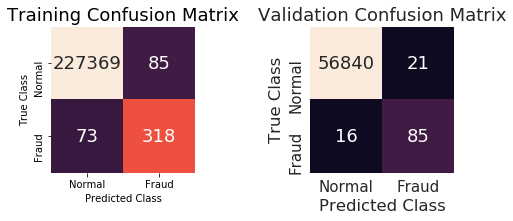

In [24]:
# Make the Confusion Matrix
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support,
                             average_precision_score)
import seaborn as sbn
LABELS = ["Normal", "Fraud"]

cm_tr = confusion_matrix(target_tr.numpy(), pred_tr_class.numpy())
cm_val = confusion_matrix(target_val.numpy(), pred_val_class.numpy())

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
sbn.set(style='whitegrid', font_scale=1.5)
sbn.heatmap(cm_tr, vmin=0, vmax=500, xticklabels=LABELS, yticklabels=LABELS, annot=True, 
            cbar=False, fmt="d")
plt.title('Training Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.subplot(1,2,2)
sbn.heatmap(cm_val, vmin=0, vmax=500, xticklabels=LABELS, yticklabels=LABELS, annot=True, 
            cbar=False, fmt="d")
plt.title('Validation Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [25]:
# Calculate and plot the Precision and Recall

result_df = pd.DataFrame({'predicted_class': pred_val_class.numpy().flatten(),
                        'actual_class':target_val.numpy(),
                        'validation_probs': val_probs})
result_df['Amount']=data_val['Amt_To_Keep'].values
result_df['Class']=data_val['Class'].values

true_positive=cm_val[1,1]
false_negative=cm_val[1,0]
true_negative=cm_val[0,0]
false_positive=cm_val[0,1]

precision=true_positive/(true_positive+false_positive)
recall=true_positive/(true_positive+false_negative)

print( 'Precision  : {:.1%}'.format(precision))
print( 'Recall     : {:.1%}'.format(recall))

Precision  : 84.2%
Recall     : 80.2%


 Average precision score: 0.7970


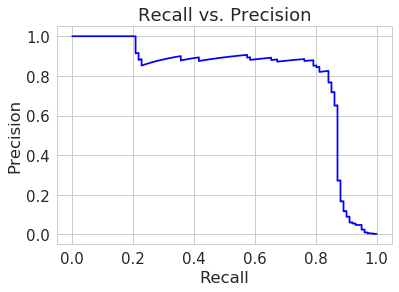

In [26]:
# Plot the precision recall curve

val_probs=pred_val_class.numpy()
precision, recall, th = precision_recall_curve(result_df.actual_class, 
                                               result_df.validation_probs)

AUPRC=average_precision_score(result_df.actual_class, result_df.validation_probs)

print(' Average precision score: {:.4f}'.format(AUPRC))

plt.plot(recall, precision, 'b', label = 'Precision-Recall Curve')
plt.title('Recall vs. Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

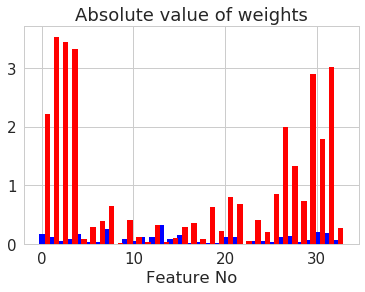

In [34]:
width=0.6
ind=np.arange(init_weights.shape[1])
rect1=plt.bar(ind, np.abs(init_weights[1,:]), width, label="Initial", color='b')
rects2=plt.bar(ind+width, np.abs(init_weights[0,:]), width, label="Initial", color='r')
plt.tick_params(axis='x', width=[ind + width*2])
plt.title('Absolute value of weights')
plt.xlabel('Feature No')
plt.show()

In [28]:
total_transactions=result_df['Amount'].sum()
total_for_actuals=result_df[result_df.Class==True].sum()
total_fraud_value=total_for_actuals['Amount']
print('Total transactions in validation set:                        {:12.4f}'.format(total_transactions))
print('Total Value of genuine fraud transactions in validation set: {:12.4f}'.format(total_fraud_value))
total_fraud_stopped=result_df[(result_df.Class==True) &(result_df.predicted_class==True)].sum()
print('Total value of fraud stopped:                                {:12.4f}'.format(total_fraud_stopped['Amount']))
print('Total value of fraud missed:                                 {:12.4f}'.format(
    total_fraud_value-total_fraud_stopped['Amount']))
missed_transactions=result_df[(result_df.Class==True) &(result_df.predicted_class==False)]




Total transactions in validation set:                        4968641.3100
Total Value of genuine fraud transactions in validation set:   11003.4700
Total value of fraud stopped:                                   7059.2300
Total value of fraud missed:                                    3944.2400
